# Рекомендация тарифов

**Описание проекта**\
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».\
\
Необходимо построить модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75.

- сalls— количество звонков,
- minutes— суммарная длительность звонков в минутах,
- messages— количество sms-сообщений,
- mb_used— израсходованный интернет-трафик в Мб,
- is_ultra— каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Открываю и изучаю файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

In [2]:
df = pd.read_csv(r'C:\Users\2011\Desktop\Data Science\Projects\02-tarifs-recommended/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
display (df.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


## Разбиваю данные на выборки

Разбиваю данные в пропорции 60-20-20 на тренировочную, валидационную и тестовую выборки

In [4]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=12345) #сначала делю данные 60-40%
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345) #беру 40% и делю их пополам 

features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

## Исследую модели

**Исследую модель решающего дерева**

Нахожу оптимальную глубину решающего дерева

In [5]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)

predictions_train = model.predict(features_train)
predictions_test = model.predict(features_test)

best_model = None
best_result = 0
accuracy_tree = []
depth_tree = []
for depth in range (1, 60):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    accuracy_tree.append(result)
    depth_tree.append(depth)
    if result > best_result:
        best_model = model
        best_result = result
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print (best_model)
#print (accuracy_tree)
#print (depth_tree)

Accuracy наилучшей модели на валидационной выборке: 0.7853810264385692
DecisionTreeClassifier(max_depth=3, random_state=12345)


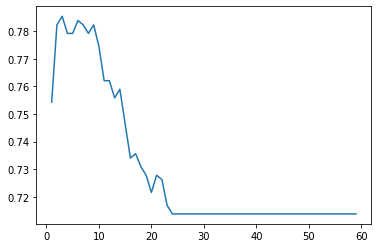

In [6]:
plt.plot(depth_tree, accuracy_tree)
plt.show()

Оптимальная глубина решающего дерева max_depth=3.\
Из графика видно, что с увеличением глубины дерева больше max_depth=3 метрика accuracy не увеличивается. При достижении max_depth=10, метрика  accuracy начинает уменьшаться.

**Исследую алгоритм классификации Случайный лес**

Нахожу оптимальное количество деревьев и их глубину

In [7]:
best_model = None
best_result = 0
for est in range(1, 11):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result:
            best_model = model
            best_result = result

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print ("Какие гиперпараметры дали наилучший результат:", best_model)

Accuracy наилучшей модели на валидационной выборке: 0.80248833592535
Какие гиперпараметры дали наилучший результат: RandomForestClassifier(max_depth=8, n_estimators=8, random_state=12345)


**Исследую модель логистической регрессии**

In [8]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
predictions = model.predict(features_train)
accuracy = model.score(features_valid, target_valid)
print ('Accuracy:', accuracy)

Accuracy: 0.7107309486780715


## Проверяю модель на тестовой выборке

**Объединяю тренировочные и валидационные данные**

In [9]:
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

In [10]:
features_train_valid.info()
features_train_valid.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2571 entries, 3027 to 3197
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     2571 non-null   float64
 1   minutes   2571 non-null   float64
 2   messages  2571 non-null   float64
 3   mb_used   2571 non-null   float64
dtypes: float64(4)
memory usage: 100.4 KB


,calls,minutes,messages,mb_used
3027,60.0,431.56,26.0,14751.26
434,33.0,265.17,59.0,17398.02
1226,52.0,341.83,68.0,15462.38
1054,42.0,226.18,21.0,13243.48
1842,30.0,198.42,0.0,8189.53
2142,68.0,403.58,28.0,19210.63
214,48.0,346.19,103.0,27346.62
1040,0.0,0.00,29.0,21289.28
2925,87.0,500.78,63.0,26115.19
943,31.0,269.94,48.0,13340.59


**Проверяю на тестовой выборке модель случайного леса**

In [11]:
model = RandomForestClassifier(max_depth=8, n_estimators=8, random_state=12345)
model.fit(features_train_valid, target_train_valid)
predictions = model.predict(features_test)

accuracy = accuracy_score(target_test, predictions)
print ('Accuracy тестовой выборки случайного леса', accuracy)

Accuracy тестовой выборки случайного леса 0.8055987558320373


## Проверяю модели на адекватность

Чтобы проверить модель на адекватность, я считаю количество 0 и 1 в столбце is_ultra 

In [12]:
nul = 0
one = 0
for i in df['is_ultra']:
    if i==0:
        nul +=1
    else:
        one +=1
print ('Количество нулей:', nul)
print ('Количество единиц:', one)
print ('Количество единиц в процентах:', 100*one/(one+nul), '%')

Количество нулей: 2229
Количество единиц: 985
Количество единиц в процентах: 30.647168637212197 %


Соотношение нулей и единиц в столбце датафрейма 31% и 69%. Значит модель, которая показывает результат accuracy больше 69% работает адекватно.

**Вывод**\
У меня были данные о поведении клиентов компании Мегалайн, которые перешли на тарифы "Смарт" или "Ультра".\
В проекте необходимо было решить задачу классификации и научить модель выбирать подходящий тариф.\
Я исследовала три модели: решающее дерево, случайный лес и логистическая регрессия. Наилучшее accuracy=0,8 показала модель случайного леса. Я проверила модель случайного леса на тестовой выборке и она также показала accuracy=0,8.